In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold,RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from copy import deepcopy
directory = "./result"
file_name = 'PhO-red.npz'
random_seed = 2024
file_path = os.path.join(directory, file_name)

PhO_red_npz = np.load(file_path, allow_pickle=True)

print("Arrays in the NPZ file:", PhO_red_npz.files)
PhO_red_data = PhO_red_npz['data']
PhO_red_columns = PhO_red_npz['columns']
physorg_react_data_df = pd.DataFrame(PhO_red_data, columns=PhO_red_columns)

physorg_react_data_df.dropna(inplace=True)  

test_index = [87, 381, 316, 120, 479, 448, 197, 507, 198, 379, 508, 313, 265, 449, 453, 89, 292, 88, 121, 266, 454, 455, 447, 456, 271, 
              269, 294, 293, 297, 248, 249, 464, 312, 499, 289, 509, 511, 267, 166, 386, 290, 392, 498, 91, 488, 7, 278, 54, 285, 94, 303, 
              358, 444, 5, 286, 98, 458, 2, 291, 268, 470, 262, 308, 272, 53, 354, 512, 360, 495, 468, 391, 310, 307, 457, 306, 258, 352, 
              305, 357, 131, 362, 42, 311, 460, 304, 510, 298, 263, 350, 368, 100, 115, 61, 500, 56, 90, 442, 277, 487, 309, 0, 1, 356]

External_index = [462,119 ,396, 273, 375, 503, 318, 504, 472, 463, 465, 341, 342, 340, 477, 327, 348, 476,423 ,377, 332, 333, 182, 181,
                  349, 183, 112, 328, 323, 324, 113, 329, 330, 331, 144, 145,149, 150, 153, 151, 152, 154, 147, 485, 148, 482, 370, 373,
                  372, 146, 371]
all_indices = set(range(len(physorg_react_data_df)))
train_val_indices = sorted(list(all_indices - set(test_index) - set(External_index)))
X = physorg_react_data_df.drop(columns=['YRed/Ox', 'compound_name'])
y = physorg_react_data_df['YRed/Ox']
X_train_val = X.iloc[train_val_indices]
y_train_val = y.iloc[train_val_indices]
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)

Arrays in the NPZ file: ['data', 'columns']


# Fine screening of hyperparameters and mapping of learning curves

In [3]:
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import GridSearchCV, KFold

model = BayesianRidge()

param_grid = {
    'alpha_1': [1e-6, 1e-5, 1e-4],
    'alpha_2': [1e-6, 1e-5, 1e-4],
    'lambda_1': [1e-6, 1e-5, 1e-4],
    'lambda_2': [1e-6, 1e-5, 1e-4]
}

kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)

Grid_search = GridSearchCV(model, param_grid, scoring='r2', cv=kfold, verbose=2, n_jobs=-1)

Grid_search.fit(X_train_val_scaled, y_train_val)

print("Best parameters:", Grid_search.best_params_)
best_model = Grid_search.best_estimator_


Fitting 10 folds for each of 81 candidates, totalling 810 fits
Best parameters: {'alpha_1': 1e-06, 'alpha_2': 0.0001, 'lambda_1': 0.0001, 'lambda_2': 1e-06}


In [4]:
rates = [int(i) for i in np.linspace(0.1, 0.9, 20) * X_train_val_scaled.shape[0]]
print(rates)

r2_list = []
r2_std_list = []
r2_train_list = []
r2_train_std_list = []
random_seed = 2024
np.random.seed(random_seed)
model = BayesianRidge( alpha_1=1e-06, alpha_2=0.0001,lambda_1 =0.0001, lambda_2 =1e-06)
kf = KFold(n_splits=10, random_state=random_seed, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_train_val_scaled, y_train_val, test_size=0.2, random_state=random_seed)
for rate in rates:
    r2s = []
    r2ts = []
    models = []
    y_pred = []
    maes = []
    rmses = []
    for train_index, val_index in kf.split(y_train):
        try:
            X_train_, X_test_, y_train_, y_test_ = train_test_split(
                X_train, y_train, train_size=rate)
        except:
            X_train_, y_train_ = X_train, y_train

        model.fit(X_train_, y_train_)
        models.append(deepcopy(model))
        y_pred.append(model.predict(X_test))
        valid_p, valid_y = model.predict(X_test), y_test
        r2 = r2_score(valid_y, valid_p)
        r2t = r2_score(model.predict(X_train_), y_train_)
        mae = mean_absolute_error(valid_y, valid_p)
        rmse = np.sqrt(mean_squared_error(valid_y, valid_p))
        r2s.append(r2)
        r2ts.append(r2t)
        maes.append(mae)
        rmses.append(rmse)
    
    valid_p, valid_y = np.array(y_pred).mean(axis=0), y_test
    r2 = np.array(r2s).mean(axis=0)
    r2_std = pd.DataFrame(r2s).std()[0]
    # print(r2_std)
    r2t = np.array(r2ts).mean(axis=0)
    r2t_std = pd.DataFrame(r2ts).std()[0]
    r2_list.append(r2)
    r2_train_list.append(r2t)
    r2_std_list.append(r2_std)
    r2_train_std_list.append(r2t_std)
    print(' $R^2$: {:.3}\n r2t: {:.3}\n r2std: {:.3}\n r2tstd: {:.3}'.format(
        r2, r2t, r2_std, r2t_std))
    
learning_curve = pd.DataFrame(columns=('r2', 'r2t', 'r2_std', 'r2t_std', 'num'))
learning_curve['r2'] = r2_list
learning_curve['r2t'] = r2_train_list
learning_curve['r2_std'] = r2_std_list
learning_curve['r2t_std'] = r2_train_std_list
learning_curve['num'] = rates
# learning_curve.to_csv('learn_curve.csv')
learning_curve

[36, 51, 67, 82, 97, 113, 128, 144, 159, 174, 190, 205, 220, 236, 251, 267, 282, 297, 313, 328]
 $R^2$: 0.678
 r2t: 0.96
 r2std: 0.123
 r2tstd: 0.0452
 $R^2$: 0.774
 r2t: 0.973
 r2std: 0.0616
 r2tstd: 0.0186
 $R^2$: 0.844
 r2t: 0.97
 r2std: 0.0456
 r2tstd: 0.0143
 $R^2$: 0.844
 r2t: 0.982
 r2std: 0.053
 r2tstd: 0.0113
 $R^2$: 0.834
 r2t: 0.975
 r2std: 0.075
 r2tstd: 0.011
 $R^2$: 0.877
 r2t: 0.973
 r2std: 0.0341
 r2tstd: 0.0104
 $R^2$: 0.893
 r2t: 0.97
 r2std: 0.0273
 r2tstd: 0.00981
 $R^2$: 0.908
 r2t: 0.972
 r2std: 0.0151
 r2tstd: 0.0116
 $R^2$: 0.904
 r2t: 0.965
 r2std: 0.0224
 r2tstd: 0.0112
 $R^2$: 0.918
 r2t: 0.967
 r2std: 0.0181
 r2tstd: 0.00857
 $R^2$: 0.913
 r2t: 0.967
 r2std: 0.0146
 r2tstd: 0.00765
 $R^2$: 0.905
 r2t: 0.966
 r2std: 0.012
 r2tstd: 0.0069
 $R^2$: 0.917
 r2t: 0.965
 r2std: 0.0185
 r2tstd: 0.00659
 $R^2$: 0.913
 r2t: 0.96
 r2std: 0.00969
 r2tstd: 0.00691
 $R^2$: 0.912
 r2t: 0.963
 r2std: 0.0104
 r2tstd: 0.00567
 $R^2$: 0.915
 r2t: 0.961
 r2std: 0.00552
 r2tstd: 

,r2,r2t,r2_std,r2t_std,num
0,0.677895,0.959916,1.234694e-01,0.045163,36
1,0.774023,0.972699,6.156371e-02,0.018582,51
2,0.843667,0.970384,4.560106e-02,0.014339,67
3,0.843775,0.982281,5.298182e-02,0.011282,82
4,0.834078,0.974552,7.496429e-02,0.010979,97
5,0.877305,0.973118,3.412717e-02,0.010435,113
6,0.892765,0.969864,2.729527e-02,0.009811,128
7,0.908240,0.972041,1.505929e-02,0.011641,144
8,0.904179,0.965337,2.237773e-02,0.011156,159
9,0.918324,0.966769,1.809994e-02,0.008573,174


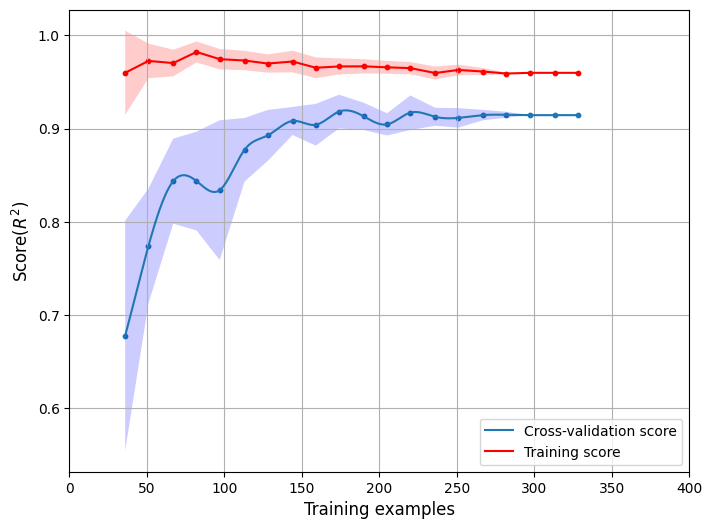

In [5]:
labels = rates 

min_label = min(labels)
max_label = max(labels)
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
r2 = learning_curve['r2']
r2t = learning_curve['r2t']
r2std = learning_curve['r2_std']
r2tstd = learning_curve['r2t_std']
labels = rates


xnew = np.linspace(min_label, max_label, 500)
func_1 = interp1d(labels, r2, kind='cubic')
r2_new = func_1(xnew)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(xnew,r2_new, '-', label = 'Cross-validation score')  
# ax.plot(labels, r2, '-', label = 'Cross-validation score')
ax.scatter(labels, r2, s=10)
ax.fill_between(labels, r2-r2std, r2+r2std, alpha=0.2, facecolor='b')


ax.plot(labels, r2t, '-r', label = 'Training score')
ax.scatter(labels, r2t, s=10, c='r')
ax.fill_between(labels, r2t-r2tstd, r2t+r2tstd, alpha=0.2, facecolor='r')
plt.xlim((0, 400))
plt.legend(loc='lower right')

ax.set_xlabel("Training examples", fontsize=12)
ax.set_ylabel("Score($R^2$)", fontsize=12)
ax.grid()
plt.savefig("./result/learning curve-PhO.svg", dpi=600)
plt.savefig('./result/learning curve-PhO.png', dpi=600)

# Feature Engineering - Feature Screening

In [7]:
'''
The dataset is divided into training/validation and out-of-sample (OOS) test sets based on predefined indices. 
The division process ensures that the test data is completely held out during the training and validation phases 
to properly evaluate the model's performance on unseen data.

- `test_index`: This is the primary set of indices used to define the initial part of the OOS test set.
- `test_index_db2`: Additional test indices derived by adding half the length of the dataset (`length_db`) to each index in `test_index`.
  This approach accounts for the potential scenario where test data points are distributed across the dataset.

The following steps are executed in the code:
1. `length_db` is calculated as half the total number of data points, used to adjust the indices for the second half of the dataset.
2. `test_index_db2` is generated to cover any test data points that might appear in the latter half of the dataset.
3. `full_test_index` combines `test_index` and `test_index_db2` to form the complete set of indices for the OOS test set.
4. The data points at these indices are then extracted as the OOS test set (`oos_x`, `oos_y`), ensuring they are not used in model training or validation.
5. The remaining data points are used to create the training/validation set (`X_scaled`, `y_train_val`), which is also standardized to aid in model training.
'''

directory = "./result"
file_name = 'PhO-red.npz'

file_path = os.path.join(directory, file_name)

PhO_red_npz = np.load(file_path, allow_pickle=True)

print("Arrays in the NPZ file:", PhO_red_npz.files)
PhO_red_data = PhO_red_npz['data']
PhO_red_columns = PhO_red_npz['columns']
physorg_react_data_df = pd.DataFrame(PhO_red_data, columns=PhO_red_columns)

physorg_react_data_df.dropna(inplace=True)  

test_index = [87, 381, 316, 120, 479, 448, 197, 507, 198, 379, 508, 313, 265, 449, 453, 89, 292, 88, 121, 266, 454, 455, 447, 456, 271, 
              269, 294, 293, 297, 248, 249, 464, 312, 499, 289, 509, 511, 267, 166, 386, 290, 392, 498, 91, 488, 7, 278, 54, 285, 94, 303, 
              358, 444, 5, 286, 98, 458, 2, 291, 268, 470, 262, 308, 272, 53, 354, 512, 360, 495, 468, 391, 310, 307, 457, 306, 258, 352, 
              305, 357, 131, 362, 42, 311, 460, 304, 510, 298, 263, 350, 368, 100, 115, 61, 500, 56, 90, 442, 277, 487, 309, 0, 1, 356]

External_index = [462,119 ,396, 273, 375, 503, 318, 504, 472, 463, 465, 341, 342, 340, 477, 327, 348, 476,423 ,377, 332, 333, 182, 181,
                  349, 183, 112, 328, 323, 324, 113, 329, 330, 331, 144, 145,149, 150, 153, 151, 152, 154, 147, 485, 148, 482, 370, 373,
                  372, 146, 371]

all_indices = set(range(len(physorg_react_data_df)))
train_val_indices = sorted(list(all_indices - set(test_index) - set(External_index)))  
X = physorg_react_data_df.drop(columns=['YRed/Ox', 'compound_name'])
y = physorg_react_data_df['YRed/Ox']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.iloc[train_val_indices])
y_train_val = y.iloc[train_val_indices]
test_x = scaler.transform(X.iloc[test_index])
test_y = y.iloc[test_index]

Arrays in the NPZ file: ['data', 'columns']


In [8]:
random_seed = 2024
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
# The max_depth and n_estimators are identified by hyperparameters optimization procedure, which is demonstrated in Notebook 3.
model = BayesianRidge( alpha_1=1e-06, alpha_2=0.0001,lambda_1 =0.0001, lambda_2 =1e-06)
cv = KFold(n_splits=10, shuffle=True, random_state=random_seed)
selector = RFECV(model, step=1, min_features_to_select=1,cv=cv, n_jobs=-1)
selector = selector.fit(X_scaled, y_train_val)
sel_index = np.where(selector.support_==True)[0]
print('----Reserved Descriptors----')
print('Size: %d'%len(sel_index))
print('Index of selected descriptors', sel_index + 1)

----Reserved Descriptors----
Size: 21
Index of selected descriptors [  2   3   4  17  18  37  40  41  42  43  46  51  57  59  61  64  65  80
  85  88 102]


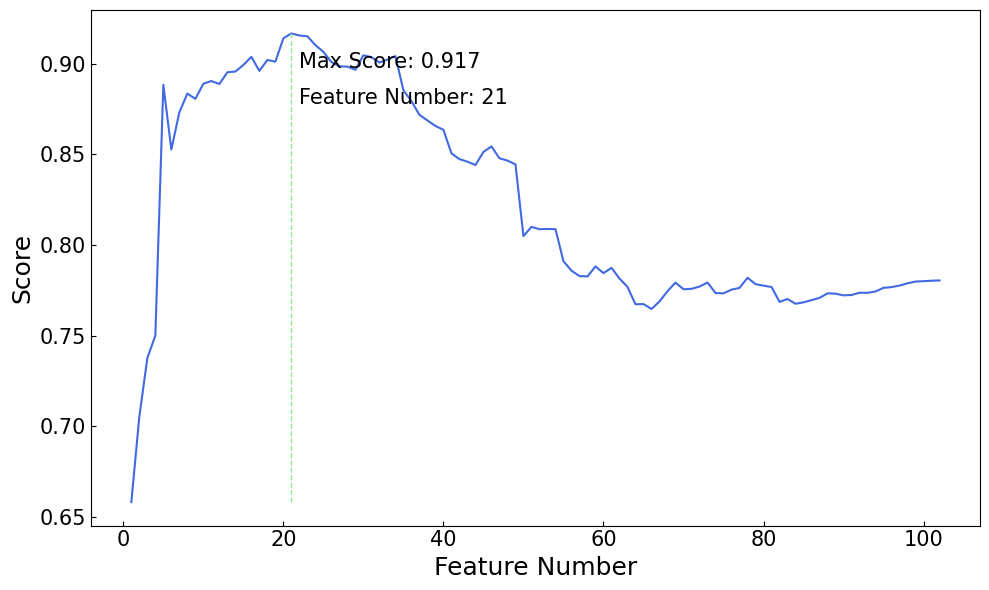

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 6))  

y_r2 = selector.cv_results_['mean_test_score']
x_1_index = [item + 1 for item in range(len(y_r2))]

max_index = np.argmax(y_r2) + 1
max_score = np.max(y_r2)

plt.plot(x_1_index, y_r2, c='royalblue')

plt.plot([max_index, max_index], [np.min(y_r2), max_score], c='lightgreen', linewidth=1, linestyle='--')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.text(max_index + 1, max_score - 0.010, f'Max Score: {max_score:.3f}', fontsize=15, verticalalignment='top')
plt.text(max_index + 1, max_score - 0.030, f'Feature Number: {max_index}', fontsize=15, verticalalignment='top')

plt.xlabel('Feature Number', fontsize=18)
plt.ylabel('Score', fontsize=18)

plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)

plt.tight_layout()
plt.savefig('./RFECV-PhO.png', dpi=600)
plt.savefig('./RFECV-PhO.tif', dpi=600)
plt.show()

# Model Training

Training Set

In [10]:
from scipy.stats import pearsonr
val_Y = []
val_P = []
kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)
for train_idx,val_idx in kfold.split(X_scaled):
    train_x,val_x = X_scaled[:,sel_index][train_idx],X_scaled[:,sel_index][val_idx]
    train_y,val_y = y_train_val.iloc[train_idx],y_train_val.iloc[val_idx]
    val_P_ = []
    for try_ in range(10): 
        model.fit(train_x,train_y)
        val_p = model.predict(val_x)
        val_P_.append(val_p)
    val_P_ = np.mean(val_P_,axis=0)
    val_P.append(val_P_)
    val_Y.append(val_y)
val_P = np.concatenate(val_P)
val_Y = np.concatenate(val_Y)
mae = mean_absolute_error(val_Y,val_P)
r2 = r2_score(val_Y,val_P)
pearson_r,_ = pearsonr(val_Y,val_P)

print("MAE: %.4f, R2: %.4f, Pearson R: %.4f"%(mae,r2,pearson_r))

MAE: 0.0664, R2: 0.9367, Pearson R: 0.9679


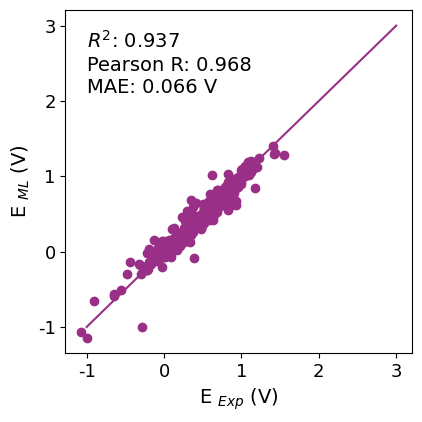

In [68]:
plt.figure(figsize=(4.5,4.5))

plt.scatter(val_Y,val_P,c='#992f87')

plt.text(-1,2.7,'$R^2$: %.3f'%r2_score(val_Y,val_P),fontsize=14)
plt.text(-1,2.4,'Pearson R: %.3f'%pearsonr(val_Y,val_P)[0],fontsize=14)
plt.text(-1,2.1,'MAE: %.3f V'%mean_absolute_error(val_Y,val_P),fontsize=14)

plt.plot([-1,3],[-1,3],c='#992f87')
plt.xlabel('E $_{Exp}$ (V)',fontsize=14)
plt.ylabel('E $_{ML}$ (V)',fontsize=14)
plt.xticks([-1, 0,1,2,3],list(map(str,[-1, 0,1,2,3])),fontsize=13)
plt.yticks([-1, 0,1,2,3],list(map(str,[-1, 0,1,2,3])),fontsize=13)

plt.tick_params(bottom='on',left='on')
plt.tight_layout()
plt.savefig('./result/CV-E-BRPhO.tif', dpi=600)  # 将图表保存为 TIFF 文件
plt.savefig('./result/CV-E-BRPhO.png', dpi=600)

Test Set

In [12]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import pearsonr

test_P = []
feature_importance = []

for _ in range(10):
    model.fit(X_scaled[:, sel_index], y_train_val)
    
    feature_importance.append(np.abs(model.coef_))
    
    test_p = model.predict(test_x[:, sel_index])
    test_P.append(test_p)

test_p = np.mean(test_P, axis=0)
feature_importance = np.mean(feature_importance, axis=0)

sel_feature_names = np.array(PhO_red_columns)[sel_index + 1]

sorted_feature_index = np.argsort(feature_importance)
importance_desc_names = sel_feature_names[sorted_feature_index]
importance_of_sel_desc = feature_importance[sorted_feature_index]

r2 = r2_score(test_y, test_p)
pearson_r, _ = pearsonr(test_y, test_p)
mae = mean_absolute_error(test_y, test_p)

print("MAE: %.4f, R2: %.4f, Pearson R: %.4f" % (mae, r2, pearson_r))

MAE: 0.0974, R2: 0.9060, Pearson R: 0.9553


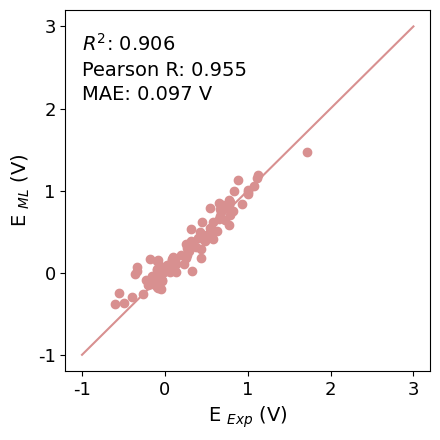

In [13]:
plt.figure(figsize=(4.5,4.5))

plt.scatter(test_y,test_p,c='#D89090')
plt.text(-1,2.7,'$R^2$: %.3f'%r2_score(test_y,test_p),fontsize=14)
plt.text(-1,2.4,'Pearson R: %.3f'%pearsonr(test_y,test_p)[0],fontsize=14)
plt.text(-1,2.1,'MAE: %.3f V'%mean_absolute_error(test_y,test_p),fontsize=14)
plt.plot([-1,3],[-1,3],c='#D89090')
plt.xlabel('E $_{Exp}$ (V)',fontsize=14)
plt.ylabel('E $_{ML}$ (V)',fontsize=14)
plt.xticks([-1,0,1,2,3],list(map(str,[-1,0,1,2,3])),fontsize=13)
plt.yticks([-1,0,1,2,3],list(map(str,[-1, 0,1,2,3])),fontsize=13)
plt.tick_params(bottom='on',left='on')
plt.tight_layout()
plt.savefig('./result/CV-E-BRPhO-oos.tif', dpi=600)  
plt.savefig('./result/CV-E-BRPhO-oos.png', dpi=600)

# Comparison of real and projected data

In [14]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
def fixed_selector_transform(X):
    return X[:, sel_index]

fixed_selector = FunctionTransformer(fixed_selector_transform)

pipeline = Pipeline([
    ('scaler', scaler),
    ('fixed_selector', fixed_selector),
    ('model', model)
])

X_full = np.vstack((X.iloc[train_val_indices], X.iloc[test_index]))  
y_full = np.concatenate((y_train_val, test_y))

pipeline.fit(X_full, y_full)

import shap
import joblib

X_scaled_full = pipeline.named_steps['scaler'].transform(X_full)
X_selected_full = pipeline.named_steps['fixed_selector'].transform(X_scaled_full)

explainer = shap.LinearExplainer(pipeline.named_steps['model'], X_selected_full)
shap_values = explainer.shap_values(X_selected_full)

joblib.dump(pipeline, 'Ered.joblib')

['Ered.joblib']

In [15]:
y_pred_full = pipeline.named_steps['model'].predict(X_selected_full)

selected_feature_names = importance_desc_names

y_true_aligned = y_full

df = pd.DataFrame(X_scaled_full[:,sel_index], columns=selected_feature_names)

df['Predicted_Y'] = y_pred_full

df['True_Y'] = y_true_aligned

missing_true_y = df['True_Y'].isna().sum()
if missing_true_y > 0:
    print(f"发现{missing_true_y}个真实值的空白，尝试修复索引对齐...")

df = df.dropna(subset=['True_Y']).reset_index(drop=True)

print(df)

df.to_csv('selected_features_and_predicted_y_with_true_y.csv', index=False)

     Overall_Variance  beta_lumo_number  Overall_Variance_2  ESPmin_2  \
0            0.389698          0.329112           -0.682524 -0.553854   
1            0.946470          0.170526           -1.045764 -0.357225   
2            0.532279          0.381851           -0.866390 -0.796655   
3           -0.635823         -0.490916            1.068775  1.009519   
4           -0.639152         -0.482529            1.063681  1.006609   
..                ...               ...                 ...       ...   
463          0.312516          0.448466           -0.726888 -0.775354   
464         -0.604921         -0.569209            1.116261  1.124899   
465          0.132346          0.223069           -0.340096 -0.283014   
466          0.355555          0.516177           -0.832815 -0.901313   
467         -0.538020         -0.412510            0.901560  0.837517   

     alpha_HOMO_LUMO_Gap_2  ALIE_Ave  Neg_Average  Vertical IP  Vertical EA  \
0                -0.623280 -0.836318     0.7

# Shap analysis and normalized presentation and data processing

Feature Importance (before and after normalization):
Neg_Average: Original SHAP Value = 22.0650, Normalized SHAP Value = 0.0143
Overall_Variance: Original SHAP Value = 23.0719, Normalized SHAP Value = 0.0150
ALIE_Ave: Original SHAP Value = 28.6579, Normalized SHAP Value = 0.0186
beta_lumo_number: Original SHAP Value = 29.2157, Normalized SHAP Value = 0.0189
Vertical IP: Original SHAP Value = 31.3987, Normalized SHAP Value = 0.0204
ESPmin_2: Original SHAP Value = 32.1621, Normalized SHAP Value = 0.0209
Overall_Variance_2: Original SHAP Value = 32.5242, Normalized SHAP Value = 0.0211
Vertical EA: Original SHAP Value = 33.7179, Normalized SHAP Value = 0.0219
beta_homo_2: Original SHAP Value = 35.6613, Normalized SHAP Value = 0.0231
Overall_Surface_Area: Original SHAP Value = 37.4384, Normalized SHAP Value = 0.0243
alpha_HOMO_LUMO_Gap_2: Original SHAP Value = 40.7294, Normalized SHAP Value = 0.0264
beta_lumo_number_2: Original SHAP Value = 61.0641, Normalized SHAP Value = 0.0396
E00: Origi

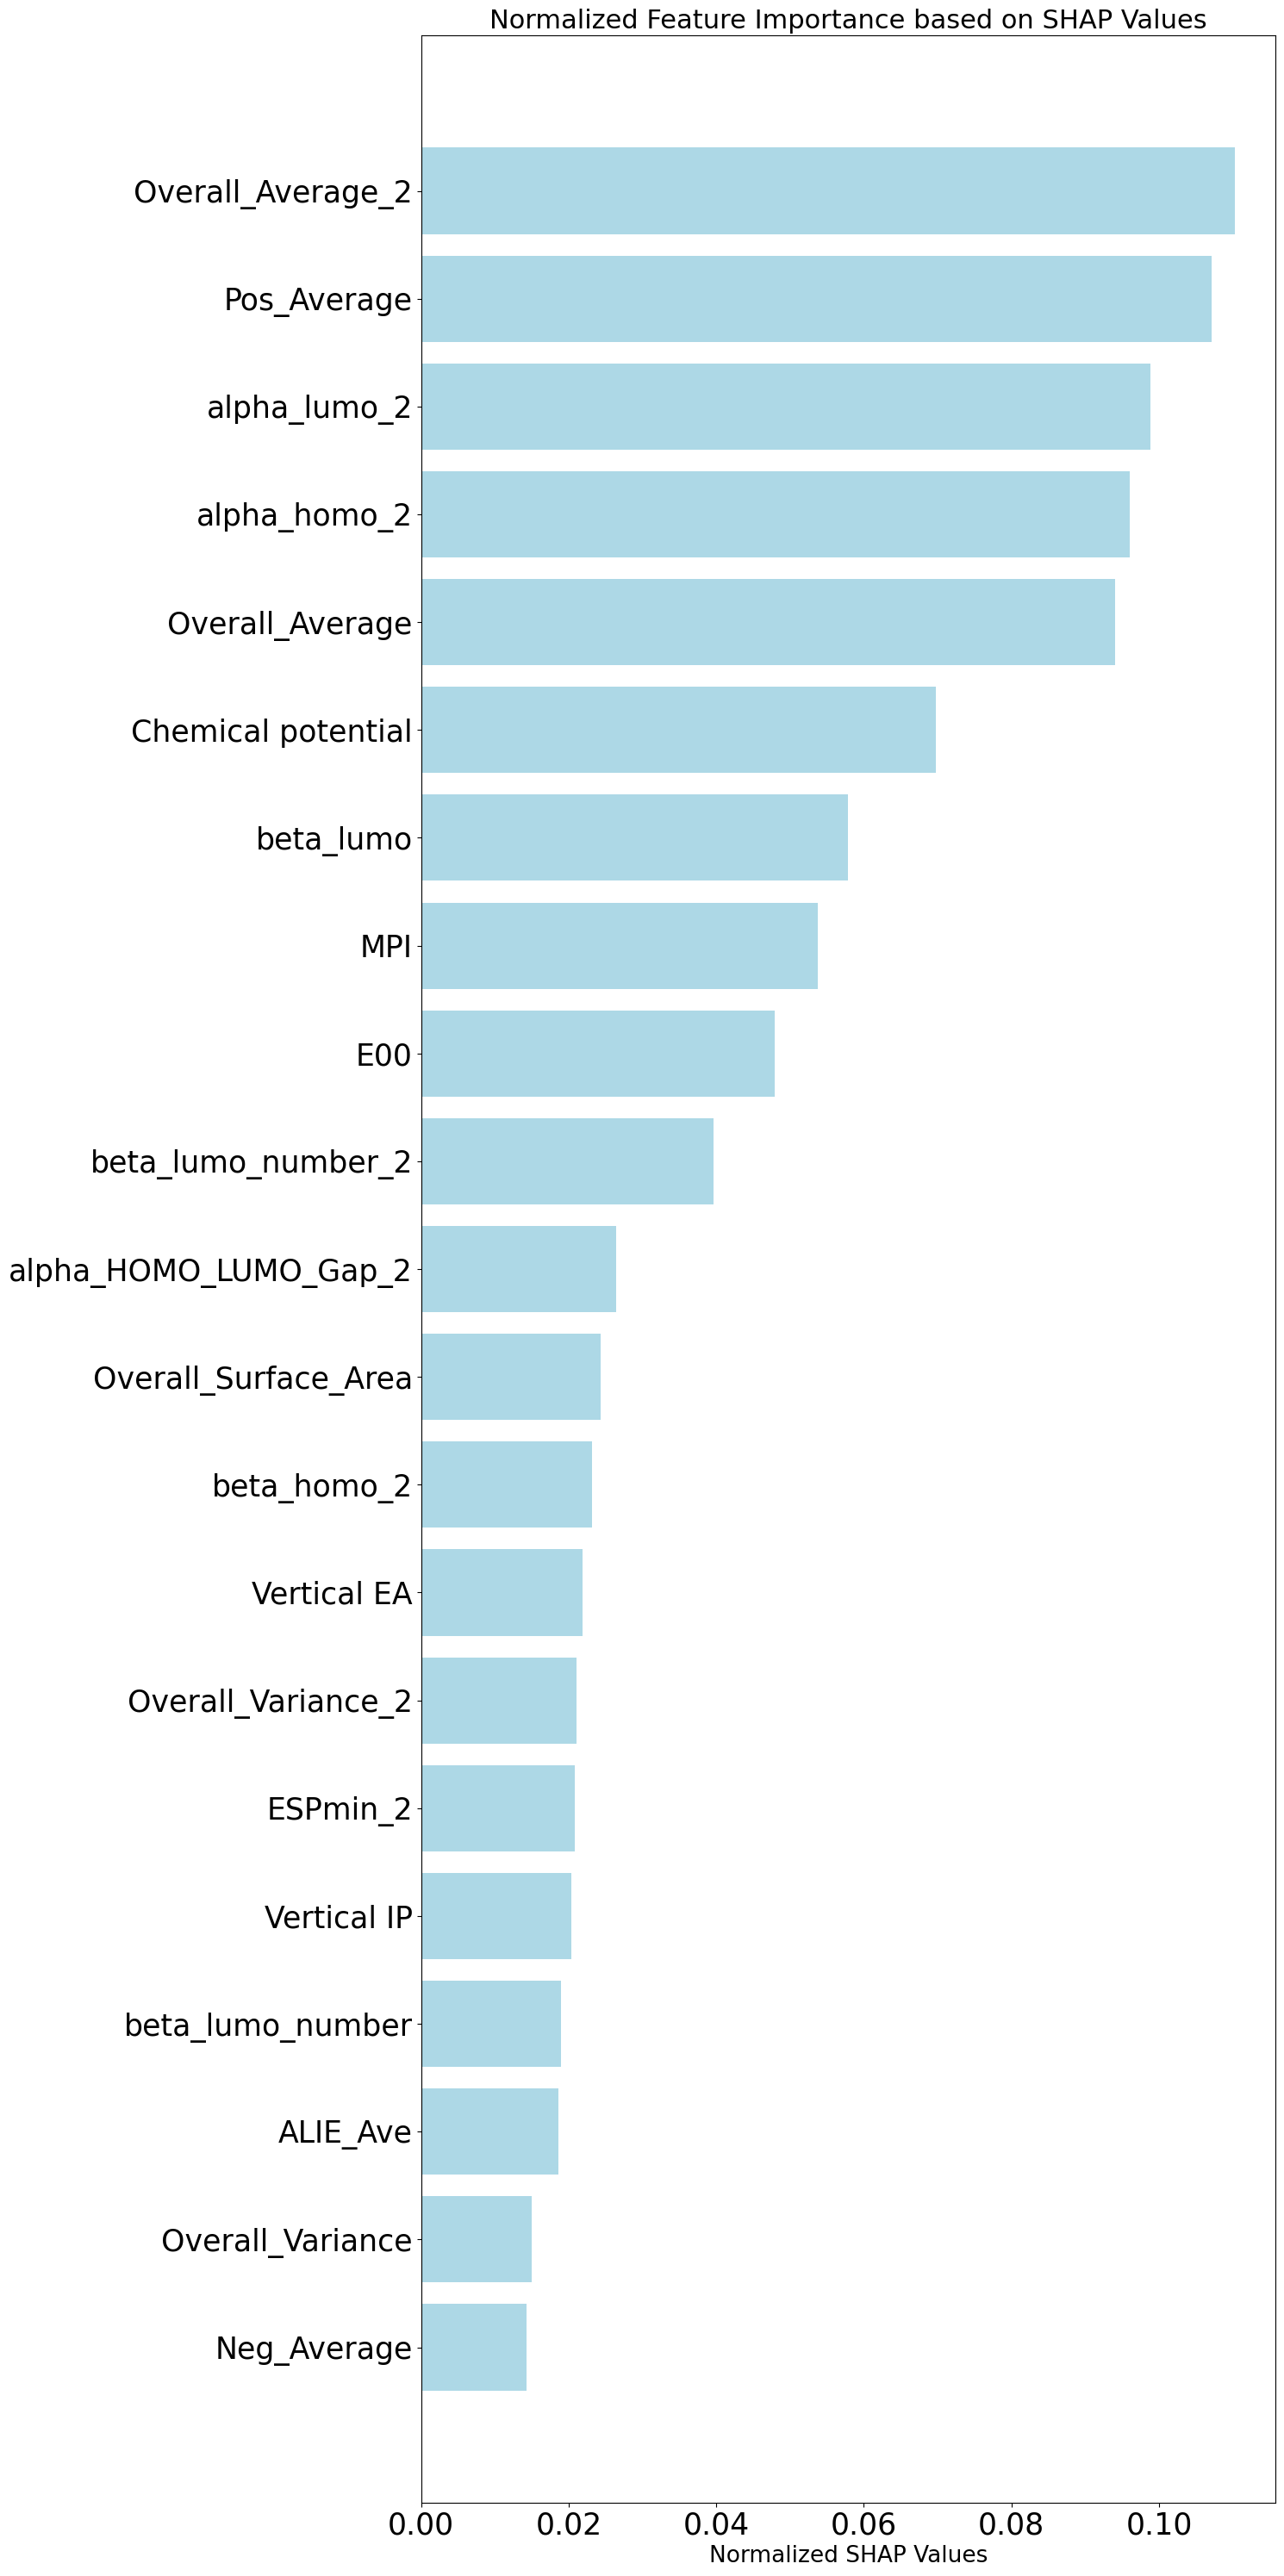

[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-05; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-05; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-05, lambda_2=1e-06; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-05, lambda_2=1e-05; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-05, lambda_2=0.0001; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=0.0001, lambda_2=1e-06; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=0.0001, lambda_2=1e-05; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-05, lambda_1=1e-06, lambda_2=1e-06; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-05, lambda_1=1e-06, lambda_2=1e-05; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-05, lambda_1=1e-06, lambda_2=0.0001; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-05, lambda_1=1e-05, lambda_2=1e-06; total time=   0.0s
[CV] E

In [17]:
shap_abs_sum = np.sum(np.abs(shap_values), axis=0)

shap_values_normalized = shap_abs_sum / np.sum(shap_abs_sum)

sorted_indices = np.argsort(shap_values_normalized)

importance_desc_names = np.array(PhO_red_columns)[sel_index + 1][sorted_indices]
importance_of_sel_desc = shap_values_normalized[sorted_indices]

print("Feature Importance (before and after normalization):")
for i in range(len(importance_desc_names)):
    print(f"{importance_desc_names[i]}: Original SHAP Value = {shap_abs_sum[sorted_indices[i]]:.4f}, Normalized SHAP Value = {importance_of_sel_desc[i]:.4f}")

fig = plt.figure(figsize=(15, 30))
plt.barh(importance_desc_names, importance_of_sel_desc, color='lightblue', align='center')
plt.xlabel('Normalized SHAP Values', fontsize=19)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Normalized Feature Importance based on SHAP Values', fontsize=22)
plt.tight_layout()

plt.savefig('./result/importance_desc_names_normalized.png', dpi=600)
plt.show()

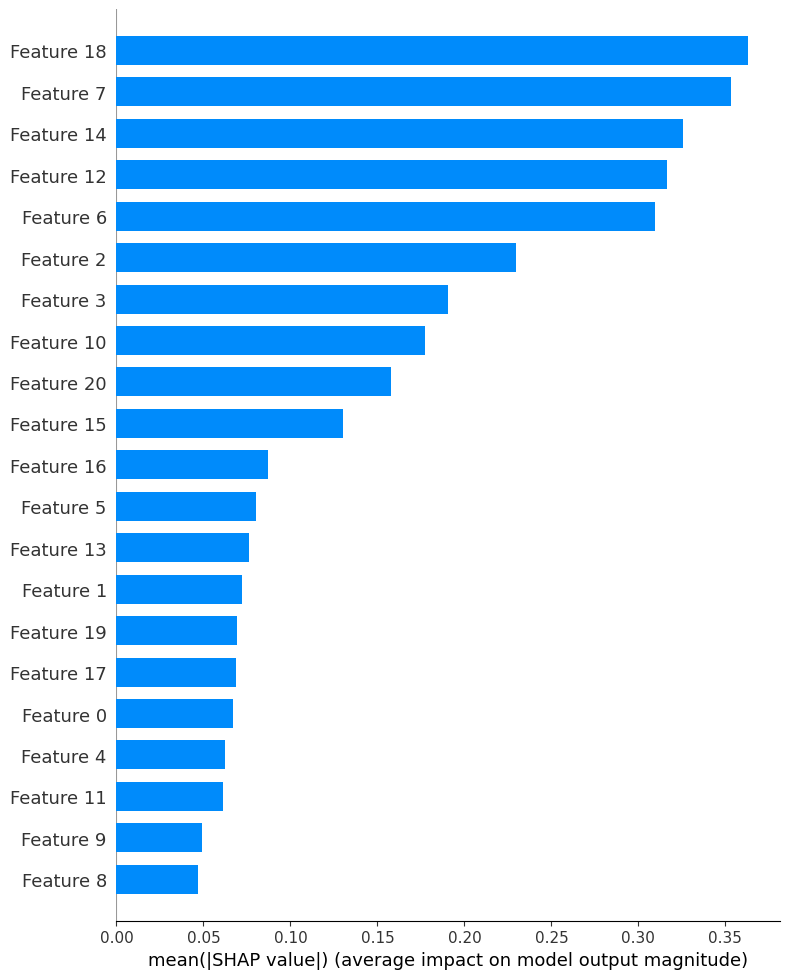

NameError: name 'PhO_rdkit_maccs_columns' is not defined

In [18]:
import shap

shap.summary_plot(
    shap_values, 
    X_selected_full, 
    plot_type="bar", 
    max_display=X_selected_full.shape[1]  
)

mean_shap_values = np.abs(shap_values).mean(axis=0)

importance_desc_names = np.array(PhO_rdkit_maccs_columns)[sel_index + 1][np.argsort(mean_shap_values)]
importance_of_sel_desc = mean_shap_values[np.argsort(mean_shap_values)]

fig = plt.figure(figsize=(15, X_selected_full.shape[1] * 0.4))
plt.barh(importance_desc_names, importance_of_sel_desc, color='lightblue', align='center')
plt.xlabel('Mean Absolute SHAP Values', fontsize=19)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


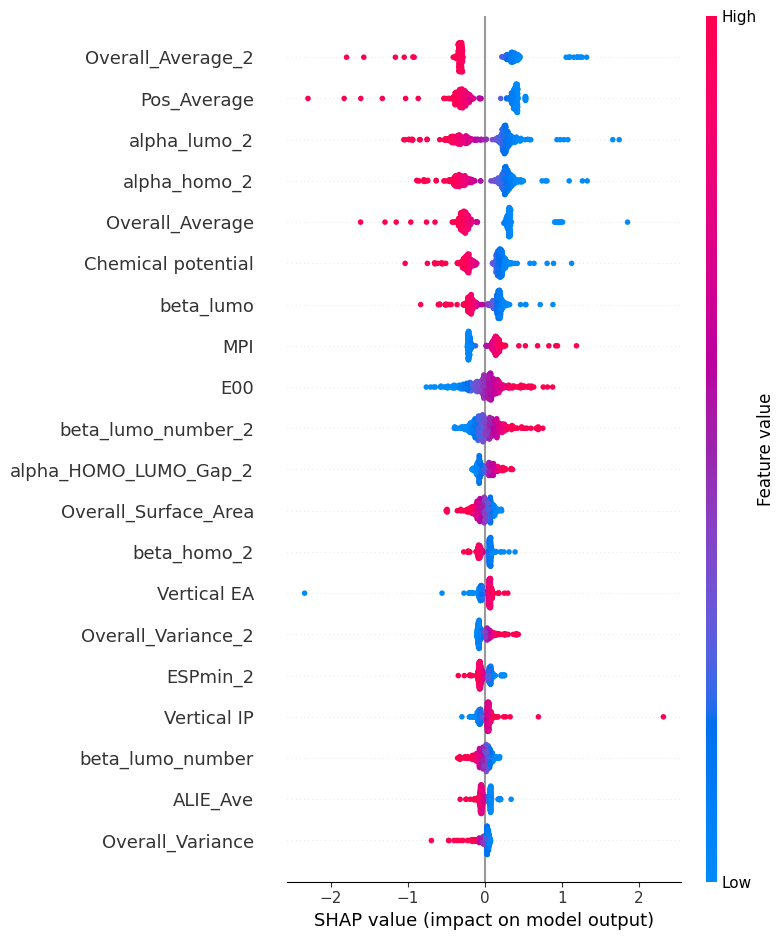

<Figure size 640x480 with 0 Axes>

In [20]:
shap.summary_plot(shap_values, X_selected_full, feature_names=np.array(PhO_red_columns)[sel_index+1])

plt.suptitle("Normalized Feature Importance based on SHAP", fontsize=20)

plt.tight_layout()
plt.savefig('./result/shap_summary_plot.png', dpi=600)
plt.show()


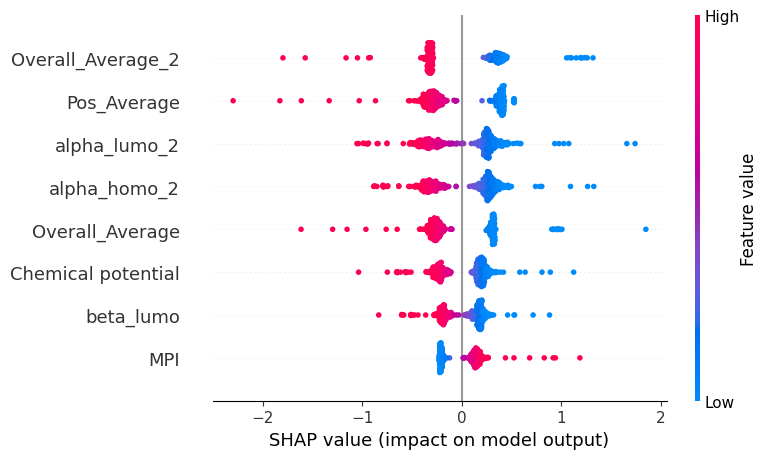

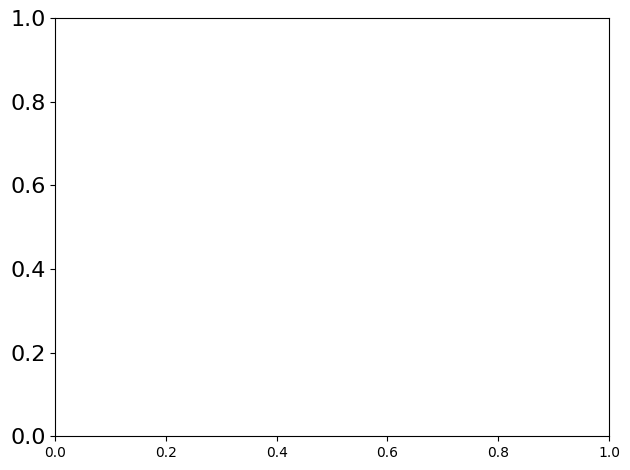

In [21]:
shap.summary_plot(shap_values, X_selected_full, feature_names=np.array(PhO_red_columns)[sel_index+1], max_display=8)

plt.gca().tick_params(axis='y', labelsize=16) 
plt.tight_layout()
plt.savefig('./result/shap_summary_plot-little.png', dpi=600)
plt.show()


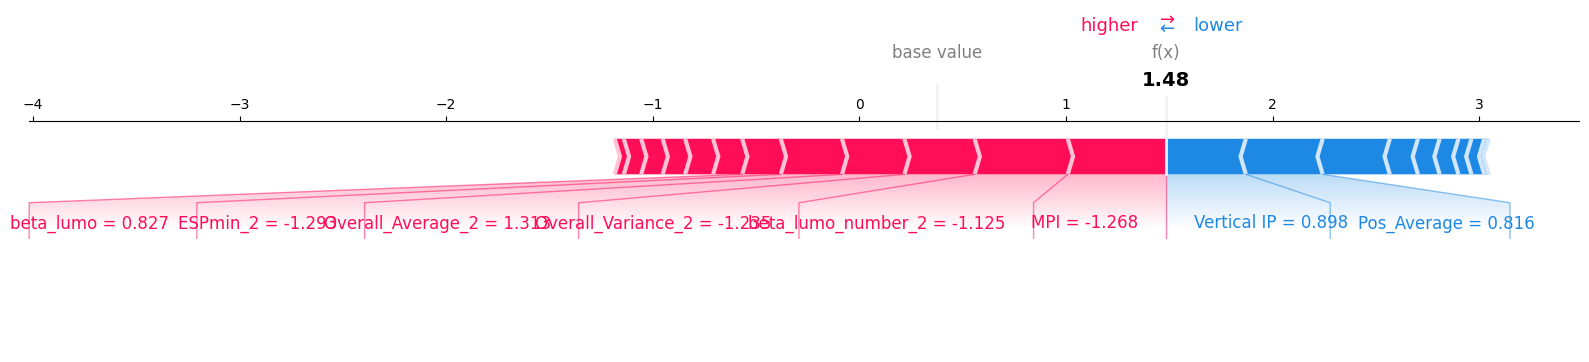

<Figure size 640x480 with 0 Axes>

In [22]:
feat_names = np.array(selected_feature_names)[: X_selected_full.shape[1]]

max_index = np.argmax(y_pred_full)

shap_values_max_sample = shap_values[max_index]
X_max_sample = X_selected_full[max_index]

X_max_sample = np.round(X_max_sample, 3)
shap_values_max_sample = np.round(shap_values_max_sample, 3)

force_plot = shap.force_plot(
    explainer.expected_value, 
    shap_values_max_sample, 
    X_max_sample, 
    feature_names=feat_names, 
    matplotlib=True
)

plt.savefig('./result/shapcolorplot-max-Y-improved.jpeg', dpi=600, format='jpeg', bbox_inches='tight')
plt.show()


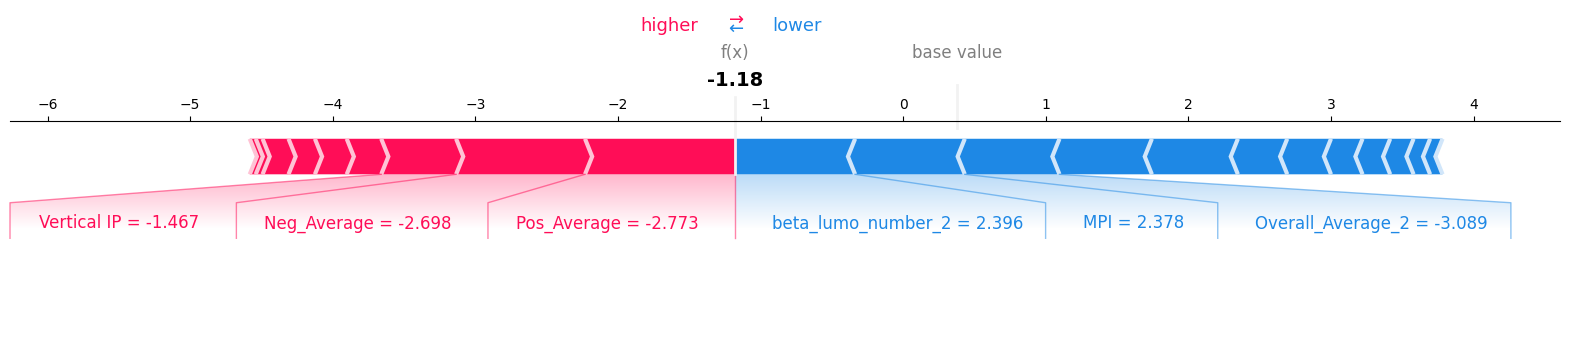

<Figure size 640x480 with 0 Axes>

In [23]:
feat_names = np.array(selected_feature_names)[: X_selected_full.shape[1]]

min_index = np.argmin(y_pred_full)

shap_values_min_sample = shap_values[min_index]
X_min_sample = X_selected_full[min_index]

X_min_sample = np.round(X_min_sample, 3)
shap_values_min_sample = np.round(shap_values_min_sample, 3)

force_plot = shap.force_plot(
    explainer.expected_value, 
    shap_values_min_sample, 
    X_min_sample, 
    feature_names=feat_names, 
    matplotlib=True
)

plt.savefig('./result/shapcolorplot-min-Y-improved.jpeg', dpi=600, format='jpeg', bbox_inches='tight')
plt.show()

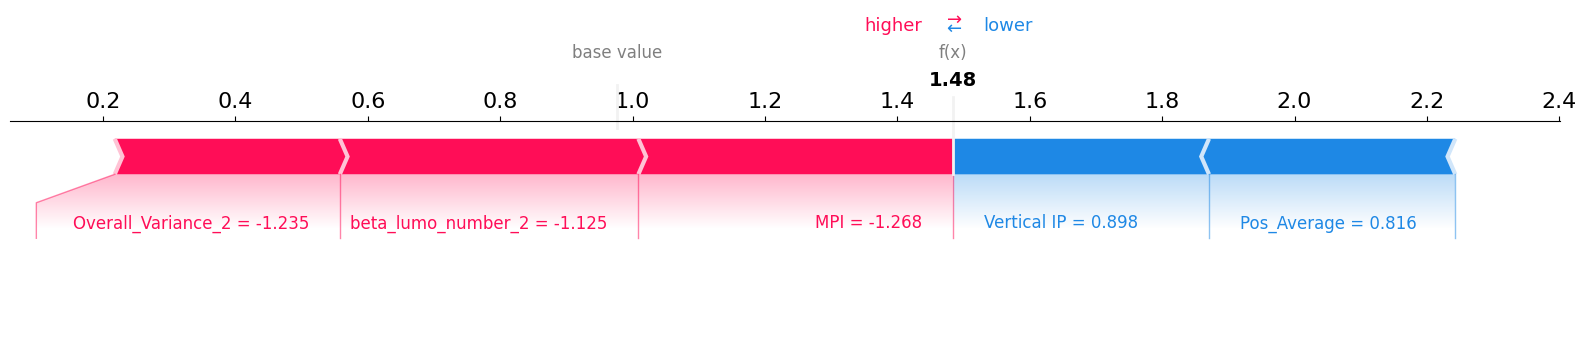

<Figure size 640x480 with 0 Axes>

In [24]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.size'] = 16

abs_shap = np.abs(shap_values_max_sample)
top5_idx = np.argsort(abs_shap)[-5:]  

order = np.argsort(shap_values_max_sample[top5_idx])
top5_idx = top5_idx[order]

X_max_sample_top5 = X_max_sample[top5_idx]
shap_values_max_sample_top5 = shap_values_max_sample[top5_idx]
feat_names_top5 = feat_names[top5_idx]

full_fx = explainer.expected_value + np.sum(shap_values_max_sample)
S_top5 = np.sum(shap_values_max_sample_top5)

expected_value_new = full_fx - S_top5

force_plot = shap.force_plot(
    expected_value_new,
    shap_values_max_sample_top5,
    X_max_sample_top5,
    feature_names=feat_names_top5,
    matplotlib=True
)

fig = plt.gcf()
for ax in fig.get_axes():
    for text in ax.texts:
        txt = text.get_text()
        x, y = text.get_position()
        if 'f(x)' in txt:
            text.set_position((x, y + 0.05))
        elif "MPI" in txt:
            text.set_position((x + 0.02, y+ 0.05))
        elif "beta_lumo_number_2" in txt:
            text.set_position((x + 0.2, y - 0.05))
        elif "Vertical IP" in txt:
            text.set_position((x - 0.03, y+0.05))
        elif "Pos_Average" in txt:
            text.set_position((x - 0.035, y+0.05))
        elif "Overall_Variance_2" in txt:
            text.set_position((x + 0.03, y+0.05))

        text.set_fontsize(18)

plt.savefig('./result/shapcolorplot-max-Y-improved_top5.jpeg', dpi=600, format='jpeg', bbox_inches='tight')
plt.show()


# Save model and out-of-bank test set testing

In [25]:
pipeline = joblib.load('Ered.joblib')
X_external = X.iloc[External_index]
y = physorg_react_data_df['YRed/Ox']
y_external = y.iloc[External_index]

ext_pred = pipeline.predict(X_external.to_numpy())
compound_names = physorg_react_data_df['compound_name']
compound_names_external = compound_names.iloc[External_index]


In [26]:
results = pd.DataFrame({
    'Compound Name': compound_names_external.values,
    'Predicted Value': ext_pred,
    'Eexp': y_external.values
})

print(results)

                         Compound Name  Predicted Value  Eexp
0                 Ir-q-bt-Me2-acac-red         0.068752  0.06
1                  Ir(dfppz)2Phtz+-red         1.061229  0.92
2                    Irppo-acacSPh-red         0.116689   0.1
3                 Ir3CFbt-HbpdcNMe-red         0.758818  0.73
4                          IrmpbiL-red        -0.157012 -0.16
5               mer-Ir(dfppz)2(pf)-red        -0.227218 -0.37
6                          IrcpbiL-red         0.330257  0.26
7              mer-Ir(dfppz)2(ptp)-red         0.002992 -0.32
8                          IrthbiL-red         0.283393  0.38
9                 Ir-q-bt-Me2-bpy+-red         0.353463   0.4
10               Ir-q-bt-Ph2-phen+-red         0.269193  0.33
11                Irdfppy-CO2Mepic-red         0.300726  0.33
12                Irdfppy-COCF3pic-red         0.449177  0.53
13                   Irdfppy-CNpic-red         0.482523  0.56
14              Ir-tPhTAZ2-phpybi+-red         0.611952  0.66
15      

[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-05; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=0.0001; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-05, lambda_2=1e-06; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-05, lambda_2=1e-05; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=0.0001, lambda_2=1e-06; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=0.0001, lambda_2=1e-05; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=0.0001, lambda_2=0.0001; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-05, lambda_1=1e-06, lambda_2=1e-06; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-05, lambda_1=1e-06, lambda_2=1e-05; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-05, lambda_1=1e-06, lambda_2=0.0001; total time=   0.0s
[CV]

[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-05; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=0.0001; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-05, lambda_2=1e-06; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-05, lambda_2=0.0001; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=0.0001, lambda_2=1e-06; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=0.0001, lambda_2=1e-05; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=0.0001, lambda_2=0.0001; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-05, lambda_1=1e-06, lambda_2=1e-06; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-05, lambda_1=1e-06, lambda_2=0.0001; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-05, lambda_1=1e-05, lambda_2=1e-06; total time=   0.0s
[CV

[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-05; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=0.0001; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-05, lambda_2=1e-05; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-05, lambda_2=0.0001; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=0.0001, lambda_2=1e-06; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=0.0001, lambda_2=1e-05; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-06, lambda_1=0.0001, lambda_2=0.0001; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-05, lambda_1=1e-06, lambda_2=1e-05; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-05, lambda_1=1e-06, lambda_2=0.0001; total time=   0.0s
[CV] END alpha_1=1e-06, alpha_2=1e-05, lambda_1=1e-05, lambda_2=1e-06; total time=   0.0s
[CV

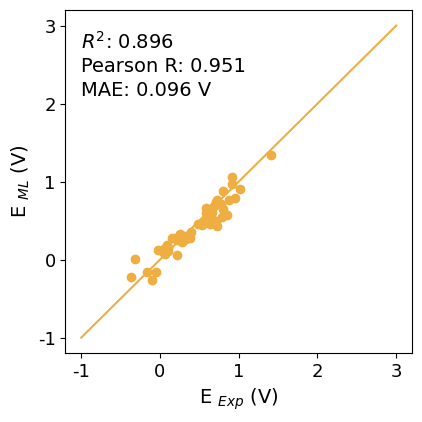

In [27]:
ext_r2 = r2_score(y_external,ext_pred)
ext_mae = mean_absolute_error(y_external,ext_pred)
ext_pearson_r = pearsonr(y_external,ext_pred)[0]

plt.figure(figsize=(4.5,4.5))

plt.scatter(y_external,ext_pred,c='#efae42')

plt.text(-1,2.7,'$R^2$: %.3f'%ext_r2,fontsize=14)
plt.text(-1,2.4,'Pearson R: %.3f'%ext_pearson_r,fontsize=14)
plt.text(-1,2.1,'MAE: %.3f V'%ext_mae,fontsize=14)

plt.plot([-1,3],[-1,3],c='#efae42')
plt.xlabel('E $_{Exp}$ (V)',fontsize=14)
plt.ylabel('E $_{ML}$ (V)',fontsize=14)
plt.xticks([-1, 0,1,2,3],list(map(str,[ -1, 0,1,2,3])),fontsize=13)
plt.yticks([ -1, 0,1,2,3],list(map(str,[-1, 0,1,2,3])),fontsize=13)
plt.tick_params(bottom='on',left='on')

plt.tight_layout()
plt.savefig('./result/external-GBRPhO.tif', dpi=600)  
plt.savefig('./result/external-GBRPhO.png',dpi =600)

# Regression curve plotting and error calculation

In [31]:
import numpy as np

def relative_error(y_pred, y_true, tol=1e-10):
    y_pred = np.asarray(y_pred, dtype=float)
    y_true = np.asarray(y_true, dtype=float)

    denom = np.abs(y_true)
    zero_mask = denom < tol                 # 记录零分母
    denom[zero_mask] = 1.0                  # 临时占位

    re = np.abs(y_pred - y_true) / denom
    re[zero_mask] = np.nan                  # 用 NaN 标记，统计时剔除
    return re

def coverage_rate(re_array, threshold):
    valid = ~np.isnan(re_array)
    return np.mean(re_array[valid] <= threshold) * 100 if valid.any() else np.nan

# 计算
re_train = relative_error(val_P, val_Y)
re_test  = relative_error(test_p, test_y)
re_ext   = relative_error(ext_pred, y_external)

for thr in (0.3, 0.2, 0.1):
    print(f"Coverage (RE ≤ {thr:0.1f}) — "
          f"train: {coverage_rate(re_train, thr):.2f}% | "
          f"test: {coverage_rate(re_test, thr):.2f}% | "
          f"external: {coverage_rate(re_ext, thr):.2f}%")
print(f"Zero-denominator samples excluded — "
      f"train: {np.isnan(re_train).sum()} | "
      f"test: {np.isnan(re_test).sum()} | "
      f"external: {np.isnan(re_ext).sum()}")


Coverage (RE ≤ 0.3) — train: 79.11% | test: 53.40% | external: 68.63%
Coverage (RE ≤ 0.2) — train: 70.75% | test: 45.63% | external: 58.82%
Coverage (RE ≤ 0.1) — train: 56.27% | test: 26.21% | external: 27.45%
Zero-denominator samples excluded — train: 6 | test: 0 | external: 0


In [61]:
import numpy as np

epsilon = 1e-10  

re_train = np.abs(val_P - val_Y) / (np.abs(val_Y) + epsilon)
re_test = np.abs(test_p - test_y) / (np.abs(test_y) + epsilon)
re_ext = np.abs(ext_pred - y_external) / (np.abs(y_external) + epsilon)

accuracy_train = np.mean(re_train <= 0.3) * 100
accuracy_test = np.mean(re_test <= 0.3) * 100
accuracy_ext = np.mean(re_ext <= 0.3) * 100
accuracy_train1 = np.mean(re_train <= 0.2) * 100
accuracy_test1 = np.mean(re_test <= 0.2) * 100
accuracy_ext1 = np.mean(re_ext <= 0.2) * 100
accuracy_train2 = np.mean(re_train <= 0.1) * 100
accuracy_test2 = np.mean(re_test <= 0.1) * 100
accuracy_ext2 = np.mean(re_ext <= 0.1) * 100

print(f"Training Accuracy (RE±0.3): {accuracy_train:.2f}%")
print(f"Test Accuracy (RE±0.3): {accuracy_test:.2f}%")
print(f"External Test Accuracy (RE±0.3): {accuracy_ext:.2f}%")
print(f"Training Accuracy (RE±0.2): {accuracy_train1:.2f}%")
print(f"Test Accuracy (RE±0.2): {accuracy_test1:.2f}%")
print(f"External Test Accuracy (RE±0.2): {accuracy_ext1:.2f}%")
print(f"Training Accuracy (RE±0.1): {accuracy_train2:.2f}%")
print(f"Test Accuracy (RE±0.1): {accuracy_test2:.2f}%")
print(f"External Test Accuracy (RE±0.1): {accuracy_ext2:.2f}%")


Training Accuracy (RE±0.3): 77.81%
Test Accuracy (RE±0.3): 53.40%
External Test Accuracy (RE±0.3): 68.63%
Training Accuracy (RE±0.2): 69.59%
Test Accuracy (RE±0.2): 45.63%
External Test Accuracy (RE±0.2): 58.82%
Training Accuracy (RE±0.1): 55.34%
Test Accuracy (RE±0.1): 26.21%
External Test Accuracy (RE±0.1): 27.45%


Training Accuracy (RE±0.3): 77.81%
Test Accuracy (RE±0.3): 53.40%
External Test Accuracy (RE±0.3): 68.63%
Training Accuracy (RE±0.2): 69.59%
Test Accuracy (RE±0.2): 45.63%
External Test Accuracy (RE±0.2): 58.82%


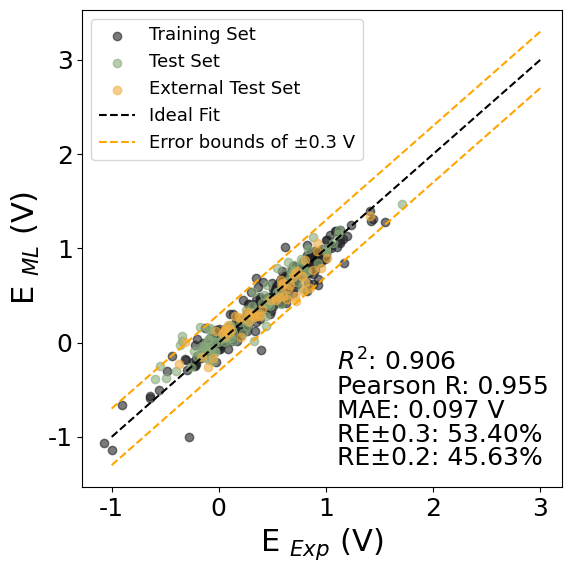

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import pearsonr
train_r2 = r2_score(val_Y, val_P)
train_pearson_r, _ = pearsonr(val_Y, val_P)
train_mae = mean_absolute_error(val_Y, val_P)

test_r2 = r2_score(test_y, test_p)
test_pearson_r, _ = pearsonr(test_y, test_p)
test_mae = mean_absolute_error(test_y, test_p)

ext_r2 = r2_score(y_external, ext_pred)
ext_mae = mean_absolute_error(y_external, ext_pred)
ext_pearson_r = pearsonr(y_external, ext_pred)[0]

epsilon = 1e-10  

re_train = np.abs(val_P - val_Y) / (np.abs(val_Y) + epsilon)
re_test = np.abs(test_p - test_y) / (np.abs(test_y) + epsilon)
re_ext = np.abs(ext_pred - y_external) / (np.abs(y_external) + epsilon)

accuracy_train = np.mean(re_train <= 0.3) * 100
accuracy_test = np.mean(re_test <= 0.3) * 100
accuracy_ext = np.mean(re_ext <= 0.3) * 100
accuracy_train1 = np.mean(re_train <= 0.2) * 100
accuracy_test1 = np.mean(re_test <= 0.2) * 100
accuracy_ext1 = np.mean(re_ext <= 0.2) * 100

print(f"Training Accuracy (RE±0.3): {accuracy_train:.2f}%")
print(f"Test Accuracy (RE±0.3): {accuracy_test:.2f}%")
print(f"External Test Accuracy (RE±0.3): {accuracy_ext:.2f}%")
print(f"Training Accuracy (RE±0.2): {accuracy_train1:.2f}%")
print(f"Test Accuracy (RE±0.2): {accuracy_test1:.2f}%")
print(f"External Test Accuracy (RE±0.2): {accuracy_ext1:.2f}%")

plt.figure(figsize=(6, 6))

plt.scatter(val_Y, val_P, c='#1F2124', label='Training Set', alpha=0.6)

plt.scatter(test_y, test_p, c='#89AA7B', label='Test Set', alpha=0.6)
plt.text(1.1, -0.3, '$R^2$: %.3f' % test_r2, fontsize=18)
plt.text(1.1,-0.55, 'Pearson R: %.3f' % test_pearson_r, fontsize=18)
plt.text(1.1,-0.80, 'MAE: %.3f V' % test_mae, fontsize=18)
plt.text(1.1,-1.05, f'RE±0.3: {accuracy_test:.2f}%', fontsize=18)
plt.text(1.1,-1.3, f'RE±0.2: {accuracy_test1:.2f}%', fontsize=18)

plt.scatter(y_external, ext_pred, c='#efae42', label='External Test Set', alpha=0.6)

plt.plot([-1,3],[-1,3],  c='black', linestyle='--', label='Ideal Fit')

plt.plot([-1, 3], [-1 + 0.3, 3 + 0.3], c='orange', linestyle='--', label='Error bounds of ±0.3 V')
plt.plot([-1, 3], [-1 - 0.3, 3 - 0.3], c='orange', linestyle='--')

plt.xlabel('E $_{Exp}$ (V)', fontsize=22)
plt.ylabel('E $_{ML}$ (V)', fontsize=22)
plt.legend(fontsize=13)

plt.xticks([-1, 0, 1, 2, 3], list(map(str, [-1, 0, 1, 2, 3])), fontsize=18)
plt.yticks([-1, 0, 1, 2, 3], list(map(str, [-1, 0, 1, 2, 3])), fontsize=18)
plt.tight_layout()

plt.savefig('./result/combined_CV_results_with_error_range_optimized.png', dpi=600)
plt.savefig('./result/combined_CV_results_with_error_range_optimized.tif', dpi=600)
plt.show() 